<a href="https://colab.research.google.com/github/Denisganga/RustAndYellowMosaicDiseaseDetection/blob/main/rust_and_yellow_mosaic_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [134]:
import torch
from torchvision import transforms, datasets
from google.colab import drive
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
# Define the path to your dataset within your Google Drive
data_dir = '/content/drive/My Drive/plant_doctor'


In [136]:
# Define transformations for preprocessing the images
transform = transforms.Compose([
    # Resize the image to a consistent size (e.g., 224x224)
    transforms.Resize((224, 224)),

    # Randomly flip the image horizontally (with a 50% probability)
    transforms.RandomHorizontalFlip(p=0.5),


    # Convert the image to a PyTorch tensor
    transforms.ToTensor(),

    # Normalize the image based on typical RGB mean and standard deviation
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [137]:
# Create a dataset using ImageFolder
# ImageFolder assumes that each subfolder in data_dir represents a different class
dataset = datasets.ImageFolder(data_dir, transform=transform)

# Define class labels based on the dataset structure
classes = dataset.classes

In [138]:
#split the dataset into training and testing tests
train_size = int(0.8*len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [139]:
print(len(dataset))
print(len(train_dataset))
print(len(test_dataset))

17
13
4


In [140]:
# Create a DataLoader for efficient data loading and batching
batch_size = 7
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_samples = len(dataset)

print(num_samples)


17


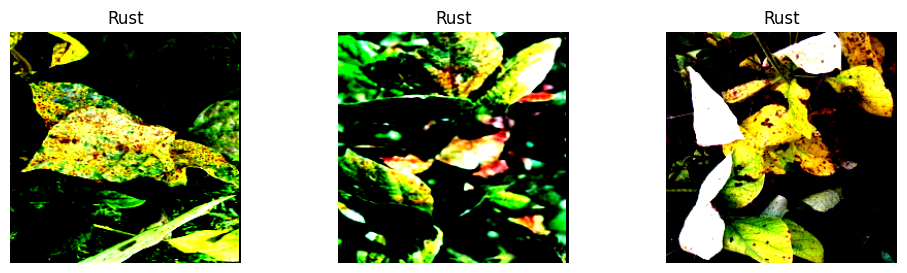

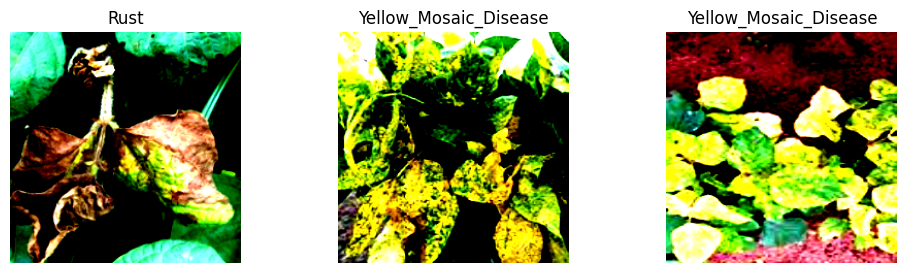

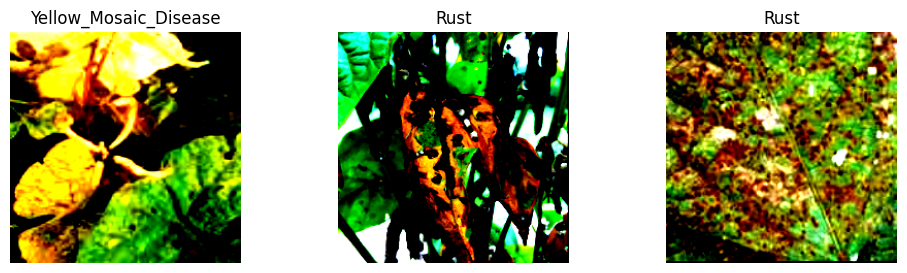

In [141]:
for images, labels in data_loader:
    fig, axs = plt.subplots(1, 3, figsize=(12, 3))
    for i in range(3):
        # Convert the image tensor to a NumPy array and transpose it to (H, W, C) format
        image = images[i].numpy().transpose((1, 2, 0))
        axs[i].imshow(image)
        axs[i].set_title(classes[labels[i]])
        axs[i].axis('off')
    plt.show()


In [142]:
#model defination
class BaselineModel(nn.Module):
    def __init__(self, num_classes):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)#3color channels(red, green, and blue),Number of Output Channels (16),Kernel Size (3x3)Common choices are 3x3 or 5x5
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(16 * 112 * 112, num_classes)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 16 * 112 * 112)
        x = self.fc(x)
        return x

num_classes = 2
baseline_model = BaselineModel(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(baseline_model.parameters(), lr=0.001)


In [143]:
#the training loop
import torch

# Assuming you have already defined your model, criterion, and optimizer
# model = BaselineModel(num_classes)
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

# Set the number of training epochs

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

num_epochs = 10

for epoch in range(num_epochs):
    baseline_model.train()  # Set the model to training mode

    running_loss = 0.0  # Initialize the running loss

    for images, labels in train_loader:  # Iterate over the training dataset
        optimizer.zero_grad()  # Zero the gradients

        # Forward pass
        outputs = baseline_model(images)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate the average training loss for the epoch
    average_loss = running_loss / len(train_loader)

    print(f'Epoch [{epoch + 1}/{num_epochs}] - Loss: {average_loss:.4f}')

print('Training complete')


Epoch [1/10] - Loss: 1.6990
Epoch [2/10] - Loss: 3.2124
Epoch [3/10] - Loss: 3.4216
Epoch [4/10] - Loss: 5.1663
Epoch [5/10] - Loss: 3.9964
Epoch [6/10] - Loss: 0.5557
Epoch [7/10] - Loss: 0.8353
Epoch [8/10] - Loss: 0.0163
Epoch [9/10] - Loss: 0.2617
Epoch [10/10] - Loss: 0.5696
Training complete


In [144]:
#define a data loader for the test dataset
test_loader = DataLoader(test_dataset,batch_size=batch_size,shuffle=False)

In [145]:
#create functions to evaluate the modelto calculate accuracy
def calculate_accuracy(model, data_loader):
  model.eval() #sets the model to evaluation mode
  correct = 0
  total = 0


  with torch.no_grad():
    for images, labels in data_loader:
      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)
      total +=labels.size(0)
      correct +=(predicted == labels).sum().item()


  return(correct /total) *100

In [146]:
#use the evaluation functions to calculate and print metrics
test_accuracy = calculate_accuracy(baseline_model, test_loader)
print(f'Test Accuracy:{test_accuracy:2f}% ')


Test Accuracy:100.000000% 


In [147]:
#saving the trained model for reuse in prediction or further training
torch.save(baseline_model.state_dict(), 'baseline_model.pth')

In [148]:
#load the model architecture
loaded_model = BaselineModel(num_classes)

#load the model weights
loaded_model.load_state_dict(torch.load('baseline_model.pth'))

<All keys matched successfully>

In [149]:
# Make sure to set the model in evaluation mode before using it for inference
loaded_model.eval()

BaselineModel(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=200704, out_features=2, bias=True)
)

In [152]:
import gdown

# Replace 'FILE_ID' with the actual file ID
file_id = '1lCbEXlLcEEUnzxPecUdu8hVR9-jj5zaB'

# Define the URL
url = f'https://drive.google.com/file/d/1lCbEXlLcEEUnzxPecUdu8hVR9-jj5zaB/view?usp=share_link'

# Download the file
gdown.download(url, output='output_filename.ext', quiet=False)

Downloading...
From: https://drive.google.com/file/d/1lCbEXlLcEEUnzxPecUdu8hVR9-jj5zaB/view?usp=share_link
To: /content/output_filename.ext
1.08MB [00:00, 48.2MB/s]


'output_filename.ext'

In [153]:
from PIL import Image
new_image = Image.open('/content/output_filename.ext')

UnidentifiedImageError: ignored